In [1]:
import model.tank_model as tank_model
import model.sugawara as sugawara
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [2]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_baseflow_separation.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)

precip = fengqiao['precipitation']
discharge = fengqiao['discharge']
et = mete['ETo_PM']

|   iter    |  target   |   Area    |    d1     |    d2     |   ecorr   |    k1     |    k2     |    k3     |    k4     |   rfcf    |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -3.034e+0 | 625.5     | 720.3     | 1.011     | 0.4419    | 0.2321    | 0.1831    | 0.2676    | 0.411     | 0.8794    |
| 2         | -3.061e+0 | 808.2     | 419.2     | 68.84     | 0.3636    | 0.8903    | 0.1246    | 0.7034    | 0.4756    | 0.9117    |
| 3         | -3.024e+0 | 210.6     | 198.1     | 80.27     | 0.9746    | 0.3821    | 0.7231    | 0.8888    | 0.9051    | 0.817     |
| 4         | -3.007e+0 | 58.58     | 169.8     | 87.94     | 0.2787    | 0.479     | 0.9621    | 0.5798    | 0.7227    | 0.8631    |
| 5         | -3.019e+0 | 1.03e+03  | 834.6     | 2.811     | 0.8001    | 0.99      | 0.7733    | 0.3524    | 0.8104    | 0.8206    |
| 6         | -3.115e+0 | 671.8     | 908.6     | 30.07     | 

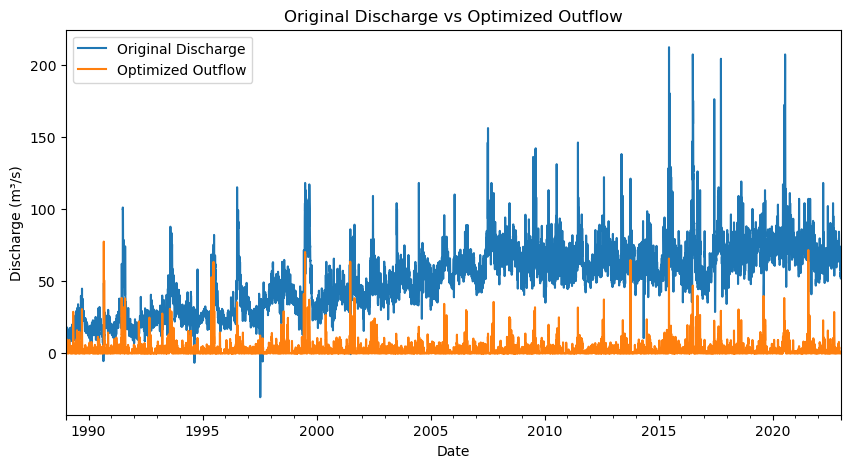

In [3]:
# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'k1': (0.1, 1),
    'k2': (0.1, 1),
    'k3': (0.1, 1),
    'k4': (0.1, 1),
    'd1': (0, 1000),
    'd2': (1, 100),
    'rfcf': (0.8, 1),
    'ecorr': (0.2, 1),
    'Area': (0, 1500),  # Add Area to the parameter bounds
}

def model_error(params):
    k1, k2, k3, k4, d1, d2, rfcf, ecorr, Area = params['k1'], params['k2'], params['k3'], params['k4'], params['d1'], params['d2'], params['rfcf'], params['ecorr'], params['Area']
    outflow, _, _ = tank_model.sugawara_model(precip, et, k1, k2, k3, k4, d1, d2, rfcf, ecorr, DT=24, AREA=Area)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # For BayesianOptimization, we maximize the function. Therefore, use negative MSE.

optimizer = BayesianOptimization(
    lambda k1, k2, k3, k4, d1, d2, rfcf, ecorr, Area: model_error({'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4, 'd1': d1, 'd2': d2, 'rfcf': rfcf, 'ecorr': ecorr, 'Area': Area}),
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=50,
)

best_params = optimizer.max['params']

# Extract the optimized parameters, including Area
k1_opt = best_params['k1']
k2_opt = best_params['k2']
k3_opt = best_params['k3']
k4_opt = best_params['k4']
d1_opt = best_params['d1']
d2_opt = best_params['d2']
rfcf_opt = best_params['rfcf']
ecorr_opt = best_params['ecorr']
Area_opt = best_params['Area']

outflow_opt, storage_1, storage_2 = tank_model.sugawara_model(precip, et, k1_opt, k2_opt, k3_opt, k4_opt, d1_opt, d2_opt, rfcf_opt, ecorr_opt, DT=24, AREA=Area_opt)

# 将优化后的结果存储在一个新的DataFrame中
results_opt = pd.DataFrame({'Date': precip.index, 'Outflow': outflow_opt, 'Storage_1': storage_1, 'Storage_2': storage_2})
results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(discharge, results_opt['Outflow'])

print(results_opt)
## Error
# 均方误差 (Mean Squared Error, MSE)

mse = mean_squared_error(discharge, results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)

rmse = mean_squared_error(discharge, results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)
# 平均绝对误差 (Mean Absolute Error, MAE)

mae = mean_absolute_error(discharge, results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)

r2 = r2_score(discharge, results_opt['Outflow'])
print('R2: ', r2)
## Figure
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
discharge.plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

In [7]:
import numpy as np

# 计算相关性
correlation_matrix = np.corrcoef(discharge, results_opt['Outflow'])

# correlation_matrix是一个2x2的矩阵，我们需要的相关性是非对角线上的元素
correlation = correlation_matrix[0, 1]

print('Correlation: ', correlation)

Correlation:  0.23410803518270715


# Underground Water

|   iter    |  target   |   Area    |    d1     |    d2     |   ecorr   |    gw     |    k1     |    k2     |    k3     |    k4     |   rfcf    |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -570.3    | 91.7      | 2.909e+03 | 1.114     | 0.8605    | 14.68     | 0.1831    | 0.2676    | 0.411     | 0.4571    | 1.016     |
| 2         | -825.7    | 91.92     | 2.772e+03 | 205.2     | 0.9756    | 2.739     | 0.7034    | 0.4756    | 0.6028    | 0.2263    | 0.8792    |
| 3         | -230.2    | 130.1     | 3.876e+03 | 314.1     | 0.9385    | 87.64     | 0.9051    | 0.1765    | 0.1351    | 0.2528    | 1.151     |
| 4         | -644.5    | 59.83     | 1.742e+03 | 957.9     | 0.9066    | 69.19     | 0.384     | 0.7179    | 0.8512    | 0.1165    | 1.1       |
| 5         | -609.0    | 148.9     | 3.018e+03 | 281.2     | 0.9579    | 10.32     | 0.5031    | 0.9177    | 0.3643    | 0.

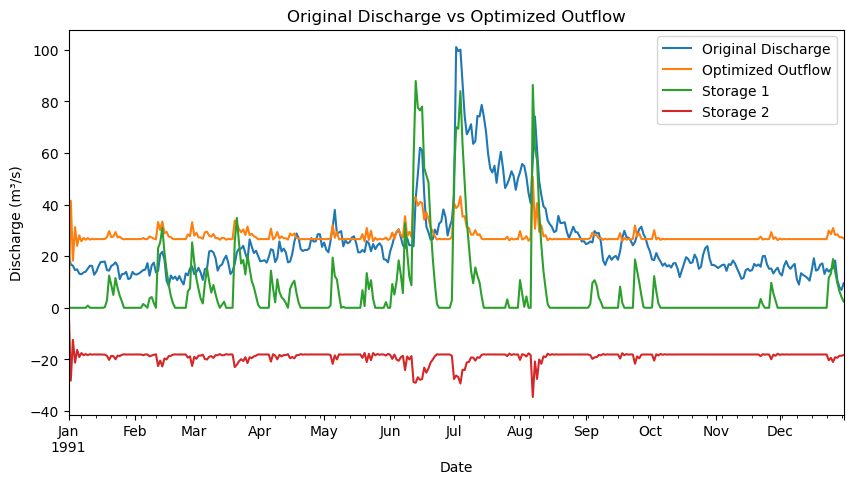

In [ ]:
# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'k1': (0.1, 1),
    'k2': (0.1, 1),
    'k3': (0.1, 1),
    'k4': (0.1, 1),
    'd1': (100, 4000),
    'd2': (1, 1000),
    'rfcf': (0.8, 1.2),
    'ecorr': (0.8, 1),
    'Area': (50, 150),  # Add Area to the parameter bounds
    'gw': (0, 100)  # Add gw to the parameter bounds
}

def model_error(params):
    k1, k2, k3, k4, d1, d2, rfcf, ecorr, Area, gw = params['k1'], params['k2'], params['k3'], params['k4'], params['d1'], params['d2'], params['rfcf'], params['ecorr'], params['Area'], params['gw']
    outflow, _, _ = tank_model.sugawara_model_gw(precip, et, k1, k2, k3, k4, d1, d2, rfcf, ecorr, DT=24, AREA=Area, gw=gw)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # For BayesianOptimization, we maximize the function. Therefore, use negative MSE.

optimizer = BayesianOptimization(
    lambda k1, k2, k3, k4, d1, d2, rfcf, ecorr, Area, gw: model_error({'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4, 'd1': d1, 'd2': d2, 'rfcf': rfcf, 'ecorr': ecorr, 'Area': Area, 'gw': gw}),
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=50,
)

best_params = optimizer.max['params']

# Extract the optimized parameters, including Area and gw
k1_opt = best_params['k1']
k2_opt = best_params['k2']
k3_opt = best_params['k3']
k4_opt = best_params['k4']
d1_opt = best_params['d1']
d2_opt = best_params['d2']
rfcf_opt = best_params['rfcf']
ecorr_opt = best_params['ecorr']
Area_opt = best_params['Area']
gw_opt = best_params['gw']

outflow_opt, storage_1, storage_2 = tank_model.sugawara_model_gw(precip, et, k1_opt, k2_opt, k3_opt, k4_opt, d1_opt, d2_opt, rfcf_opt, ecorr_opt, DT=24, AREA=Area_opt, gw=gw_opt)

# 将优化后的结果存储在一个新的DataFrame中
results_opt = pd.DataFrame({'Date': precip.index, 'Outflow': outflow_opt, 'Storage_1': storage_1, 'Storage_2': storage_2})
results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(discharge, results_opt['Outflow'])

print(results_opt)
## Error
# 均方误差 (Mean Squared Error, MSE)

mse = mean_squared_error(discharge, results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)

rmse = mean_squared_error(discharge, results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)

# 平均绝对误差 (Mean Absolute Error, MAE)

mae = mean_absolute_error(discharge, results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)

r2 = r2_score(discharge, results_opt['Outflow'])
print('R2: ', r2)
## Figure
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
discharge.plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')
results_opt['Storage_1'].plot(ax=ax, label='Storage 1')
results_opt['Storage_2'].plot(ax=ax, label='Storage 2')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()
plt.show()